<a href="https://colab.research.google.com/github/rlackdrhkd/Do-it-deep-learning/blob/main/Do_it_%EB%94%A5%EB%9F%AC%EB%8B%9D_6%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import numpy as np
import matplotlib.pyplot as plt

In [51]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x=cancer.data
y=cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y,stratify=y,
                                                            test_size=0.2,random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all, test_size=0.2, random_state=42)

In [52]:
print(x_train.shape,x_val.shape)

(364, 30) (91, 30)


In [53]:
class SingleLayer:

  def __init__(self, learning_rate=0.1, l1=0, l2=0): #Add learing rate parameter and variable to record weight
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses= []
    self.w_history = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self,x):  # Calculation Straight line
    z = np.dot(x,self.w) + self.b
    return z

  def backprop(self, x, err):
    m = len(x)
    w_grad = np.dot(x.T, err) / m      # Calculation gradient about weight
    b_grad = np.sum(err) / m      # Calculation gradient about intercept    
    return w_grad, b_grad
  
  def add_bias(self, x): #Adds a column vector filled with 1 at the beginning of the matrix
    return np.c_[np.ones((x.shape[0],1)),x]

  def activation(self,z): #Calculation sigmoid
    a = 1 / (1+ np.exp(-z)) #Perform forpass calculation
    return a                 #Apply step function

  def update_val_loss(self,x_val,y_val):   
    z = self.forpass(x_val)                   #Perform forpass calculation                       
    a = self.activation(z)                    #Apply step function                      
    z = np.clip(a, 1e-10, 1-1e-10)
    #Add list pluses reg_loss and val_loss
    val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

  def fit(self,x,y,epochs=100,x_val=None,y_val=None):      #Record weight and controll update volume
    y = y.reshape(-1,1)                        #Change target to column vector
    y_val = y_val.reshape(-1,1)                #Change validation target to column vector
    m = len(x)                                 #Count and Save Sample
    self.w = np.ones((x.shape[1],1))           #reset weight
    self.b = 0                                 #reset intercept
    self.w_history.append(self.w.copy())       #record weight
    #repeat as many as epochs
    for i in range(epochs):
      z = self.forpass(x)                      #perfrom forpass Calculation
      a = self.activation(z)                   #Apply activation function
      err = -(y-a)                             #Calculate error
      #Calculation gradient to backprop err
      w_grad, b_grad = self.backprop(x,err)
      #Plus differential value of penalty function to gradient
      w_grad += (self.l1*np.sign(self.w) + self.l2 * self.w) / m
      #Update weight and intercept
      self.w -= self.lr * w_grad
      self.b -= self.lr * b_grad
      self.w_history.append(self.w.copy())
      a = np.clip(a, 1e-10, 1-1e-10)
      loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
      self.losses.append((loss + self.reg_loss()) / m)
      #Calculate loss about validation set
      self.update_val_loss(x_val,y_val)

  def predict(self,x):
    z = self.forpass(x) #forpass calculation
    return z > 0               #apply stair function

  def score(self,x,y):
    #return true rate and compare prediction and column vector
    return np.mean(self.predict(x) == y.reshape(-1,1))

  def reg_loss(self):
    return self.l1* np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [55]:
single_layer = SingleLayer(l2=0.01)
single_layer.fit(x_train_scaled,y_train,
                 x_val=x_val_scaled, y_val=y_val, epochs=10000)
single_layer.score(x_val_scaled,y_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


0.978021978021978

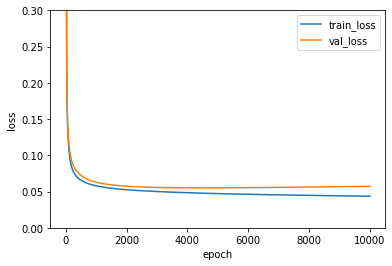

In [56]:
plt.ylim(0,0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

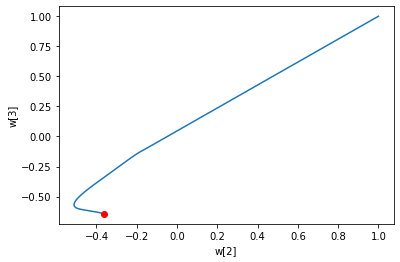

In [57]:
w2 = []
w3 = []
for w in single_layer.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2,w3)
plt.plot(w2[-1],w3[-1],'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

In [71]:
class DualLayer(SingleLayer):

  def __init__(self,units=10,learning_rate=0.1,l1=0,l2=0):
    self.units = units        #Number of neurons in the hidden layer
    self.w1 = None            #weight of the hidden layer
    self.b1 = None            #intercept of the hidden layer
    self.w2 = None            #weight of the output layer
    self.b2 = None            #intercept of the output layer
    self.a1 = None            #activation output of the hidden layer
    self.losses = []          #train losses
    self.val_losses = []      #validation losses
    self.lr = learning_rate   #learning rate
    self.l1 = l1              #l1 loss hyperparameter
    self.l2 = l2              #l2 loss hyperparameter

  def forpass(self,x):
    z1 = np.dot(x,self.w1) + self.b1         #calculate linear expression of first layer
    self.a1 = self.activation(z1)            #Apply activation function
    z2 = np.dot(self.a1, self.w2) + self.b2  #calculate linear expressing of second layer
    return z2

  def backprop(self,x,err):
    m = len(x)
    w2_grad = np.dot(self.a1.T,err) / m
    b2_grad = np.sum(err) / m
    err_to_hidden = np.dot(err,self.w2.T) * self.a1 * (1-self.a1)
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

  def init_weights(self, n_features):
    self.w1 = np.ones((n_features, self.units))     #(Numbers of features,Size of the hidden layer)
    self.b1 = np.zeros(self.units)                  #Size of the hidden layer
    self.w2 = np.ones((self.units,1))               #(Size of the hidden layer,1)
    self.b2 = 0

  def fit(self,x,y,epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1,1)
    y_val = y_val.reshape(-1,1)
    m = len(x)
    self.init_weights(x.shape[1])
    for i in range(epochs):
      a = self.training(x,y,m)
      a = np.clip(a,1e-10,1-1e-10)
      loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
      self.losses.append((loss + self.reg_loss()) / m)
      self.update_val_loss(x_val,y_val)

  def training(self,x,y,m):
    z = self.forpass(x)
    a = self.activation(z)
    err = -(y-a)
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x,err)
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a

  def reg_loss(self):
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
           self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

In [72]:
dual_layer = DualLayer(l2=0.01)
dual_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=20000)
dual_layer.score(x_val_scaled, y_val)

0.978021978021978

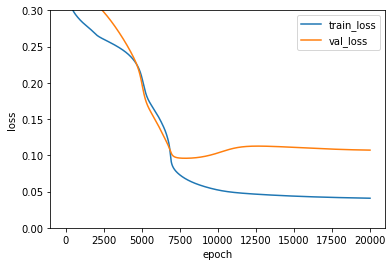

In [74]:
plt.ylim(0,0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

**Modify init_weights method for weight reset**

In [76]:
class RandomInitNetwork(DualLayer):

  def init_weights(self,n_features):
    np.random.seed(42)
    self.w1 = np.random.normal(0,1,
                               (n_features, self.units))
    self.b1 = np.zeros(self.units)
    self.w2 = np.random.normal(0,1,(self.units,1))
    self.b2 = 0

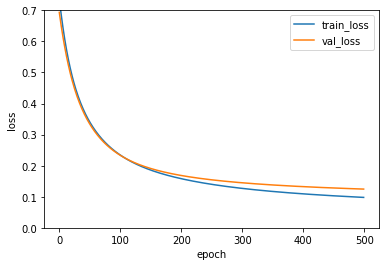

In [81]:
random_init_net = RandomInitNetwork(l2=0.01)
random_init_net.fit(x_train_scaled,y_train,
                    x_val = x_val_scaled, y_val=y_val,epochs=500)
plt.ylim(0, 0.7)
plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

**Training Model using mini batch**

In [120]:
class MinibatchNetwork(RandomInitNetwork):

  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
    super().__init__(units, learning_rate, l1, l2)
    self.batch_size = batch_size    #Size of Batch

  def fit(self,x,y,epochs=100,x_val=None,y_val=None):
    y = y.reshape(-1,1)                   #Change target to column vector
    y_val = y_val.reshape(-1,1)
    self.init_weights(x.shape[1])         #reset weight of the hidden and output layer
    np.random.seed(42)
    #Reset as many as epochs
    for i in range(epochs):
      loss=0
      #Circulate returned mini batch from generate function
      for x_batch, y_batch in self.gen_batch(x,y):
        y_batch = y_batch.reshape(-1,1)           #Change target to column vector
        m = len(x_batch)                          #Save number of sample
        a = self.training(x_batch, y_batch,m)
        #Cliping for save log calculation
        a = np.clip(a,1e-10,1-1e-10)
        #Add log loss and regulatory loss to the list
        loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
      self.losses.append((loss + self.reg_loss()) / len(x))
      #Calculate loss about validation loss
      self.update_val_loss(x_val,y_val)

    # generate function of mini_batch
  def gen_batch(self,x,y):
    length = len(x)
    bins = length // self.batch_size      #Number of mini batch   
    if length % self.batch_size:
      bins += 1                           #when they are not separated
    indexes = np.random.permutation(np.arange(len(x))) #Mix the index
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i+1)
      yield x[start:end], y[start:end]  #Slices by batch size and returns

In [121]:
minibatch_net = MinibatchNetwork(l2=0.01, batch_size=32)
minibatch_net.fit(x_train_scaled,y_train,x_val=x_val_scaled,y_val=y_val,
                  epochs=500)
minibatch_net.score(x_val_scaled, y_val)

0.978021978021978

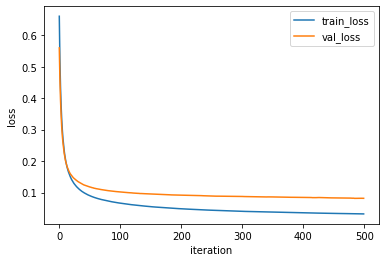

In [122]:
plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss','val_loss'])
plt.show()

In [125]:
minibatch_net = MinibatchNetwork(l2=0.01, batch_size=128)
minibatch_net.fit(x_train_scaled, y_train, x_val= x_val_scaled, y_val=y_val, epochs=500)
minibatch_net.score(x_val_scaled,y_val)

0.978021978021978

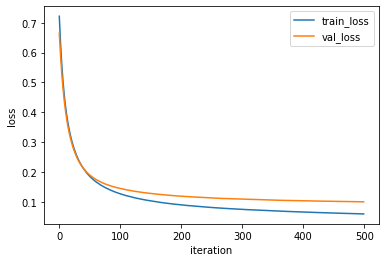

In [126]:
plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss','val_loss'])
plt.show()

**Training Multi-layer-Percepton**

In [127]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic',
                    solver='sgd', alpha=0.01, batch_size=32,
                    learning_rate_init=0.1, max_iter=500)

In [129]:
mlp.fit(x_train_scaled,y_train)
mlp.score(x_val_scaled,y_val)

0.978021978021978